## Show different condition results in table

In [14]:
import json

with open("tmp_test.json") as f:
    logs = json.load(f)

from prettytable import prettytable

table = prettytable.PrettyTable()
table.field_names = ["weather", "timeofday", "scene","samples","mIoU"]
tt = 0
for log in logs:
    table.add_row([log['condition']['weather'], log['condition']['timeofday'], 
                  log['condition']['scene'], log['val samples'], 
                  "{:.2f}".format(log['metrics'])])
    tt += log['val samples']

print(tt)    
table.sortby = "mIoU"
table.reversesort = True
print(table)


    

9866
+---------------+-----------+-------------+---------+------+
|    weather    | timeofday |    scene    | samples | mIoU |
+---------------+-----------+-------------+---------+------+
|    overcast   | dawn/dusk |   highway   |    50   | 0.82 |
|     clear     |  daytime  |   highway   |   514   | 0.81 |
|     clear     | dawn/dusk |   highway   |    88   | 0.81 |
|    overcast   |  daytime  |   highway   |   279   | 0.80 |
|     clear     |   night   |   highway   |   883   | 0.80 |
| partly cloudy |  daytime  |   highway   |   231   | 0.79 |
|   undefined   |   night   |   highway   |    18   | 0.78 |
|    overcast   | dawn/dusk | city street |   109   | 0.77 |
| partly cloudy | dawn/dusk |   highway   |    36   | 0.76 |
|    overcast   |  daytime  | city street |   597   | 0.76 |
|   undefined   |  daytime  |   highway   |   107   | 0.75 |
|     rainy     |  daytime  |   highway   |    87   | 0.74 |
|   undefined   |  daytime  | city street |   716   | 0.73 |
|   undefined   | d

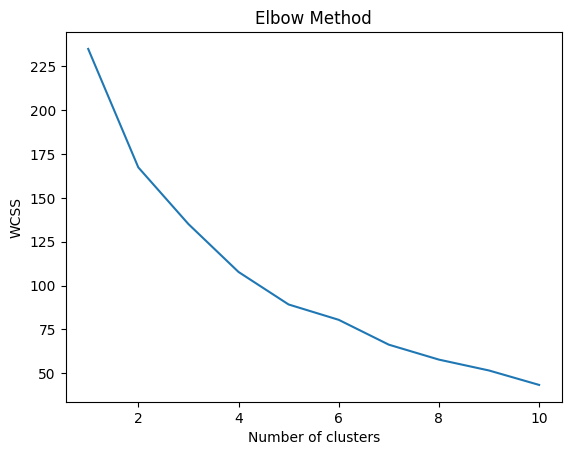

          weather  timeofday        scene  samples  mIoU  Cluster
0        overcast  dawn/dusk      highway       50  0.82        1
1           clear    daytime      highway      514  0.81        1
2           clear  dawn/dusk      highway       88  0.81        1
3        overcast    daytime      highway      279  0.80        1
4           clear      night      highway      883  0.80        1
5   partly cloudy    daytime      highway      231  0.79        1
6       undefined      night      highway       18  0.78        1
7        overcast  dawn/dusk  city street      109  0.77        1
8   partly cloudy  dawn/dusk      highway       36  0.76        1
9        overcast    daytime  city street      597  0.76        1
10      undefined    daytime      highway      107  0.75        1
11          rainy    daytime      highway       87  0.74        1
12      undefined    daytime  city street      716  0.73        1
13      undefined  dawn/dusk  residential       15  0.73        1
14      un

: 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# print(table.get_csv_string())
with open('table.csv', 'w') as f:
    f.write(table.get_csv_string())
# create a pandas DataFrame
df = pd.read_csv('table.csv')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# select fields to cluster
X = df[['weather', 'timeofday', 'scene', 'samples', 'mIoU']]

# convert categorical variables to numeric
X['weather'] = pd.factorize(X['weather'])[0]
X['timeofday'] = pd.factorize(X['timeofday'])[0]
X['scene'] = pd.factorize(X['scene'])[0]

# scale numerical variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# determine the number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# cluster the data
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=20, random_state=0)
pred_y = kmeans.fit_predict(X_scaled)

# add cluster labels to dataframe
df['Cluster'] = pred_y
print(df)

## Set params

In [ ]:
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

config_file = '/home/zekun/drivable/models/config-deeplabv3.py'
checkpoint_file = "/home/zekun/drivable/outputs/deeplabv3_backbone_refined_benchmark-20230427_225904.pth"

output_size = (769,769)

from lib.utils import load_mmcv_checkpoint
backbone = load_mmcv_checkpoint(config_file, checkpoint_file)

from models.modelInterface import BDD100kModel

model = BDD100kModel(num_classes=3, backbone=backbone, size=output_size)
# model = load_checkpoint(model, "test-20230402_144923.pth", OUTPUT_DIR)
model.to(DEVICE)

In [35]:
model.cpu()
model.backbone.cpu()
torch.cuda.empty_cache()

: 

## Show prediction of specific image

In [ ]:
image_name = "data/bdd100k/images/100k/val/b1ceb32e-51852abe.jpg"

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, Normalize

# Load the image and preprocess it
image = Image.open(image_name)
image = image.resize((769, 769))
image_tensor = ToTensor()(image)
# image_tensor = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor)
image_tensor = image_tensor.unsqueeze(0).to(DEVICE)

# Pass the image through the model and obtain the predicted output
with torch.no_grad():
    output = model(image_tensor)
    # output = output.detach().cpu().numpy()
    output = torch.argmax(output, dim=1).squeeze().detach().cpu().numpy()

# image = np.transpose(image_tensor.cpu().numpy(), (1, 2, 0))  # Add batch dimension

# Convert the predicted output to a color-coded mask
mask = np.zeros((output.shape[0], output.shape[1], 3))
mask[output == 0] = [0, 1, 0]  # Direct
mask[output == 1] = [0, 0, 1]  # Alternative   
mask[output == 2] = [0, 0, 0]  # Background

image_np = np.array(image)
# Overlay the mask on top of the input image
alpha = 0.3
# overlay = (alpha * mask + image_np)

# Visualize the output by displaying the image and overlaying the predicted mask

plt.imshow(mask)

# mask = output[0, 1]  # Take the second channel of the output tensor as the predicted mask
# plt.contourf(mask, cmap='coolwarm', alpha=0.5)
plt.show()

## Parse json logs to csv file

In [ ]:
import json
with open(f'./bdd100k-eval-result.json', "r") as f:
    results = json.load(f)

print(results[1]["condition"])

items = dict()
for item in results:
    model = item["model"]
    if item["condition"] == None:
        l = "all"
    else:
        if "rainy" in item["condition"]["weather"]:
            if "daytime" in item["condition"]["timeofday"]:
                l = "other_daytime"
            else:
                l = "other_night"
        else:
            if "daytime" in item["condition"]["timeofday"]:
                l = "clear_daytime"
            else:
                l = "clear_night"
    if model not in items.keys():
        items[model] = dict()
    items[model][f"mIoU-{l}"] = item["metrics"]["IoU"][1]["AVERAGE"]
    items[model][f"Acc-{l}"] = item["metrics"]["Acc"][1]["AVERAGE"]

print(items.keys())

ll = ["all", "other_daytime", "other_night", "clear_daytime", "clear_night"]
keys = []
for l in ll:
    keys.append(f"mIoU-{l}")
    keys.append(f"Acc-{l}")

print(["model"] + keys)

import csv

with open('bdd100k-eval-result.csv', 'w', newline='') as file:

    # create a CSV writer object
    writer = csv.writer(file)

    # write a header row
    writer.writerow(["model name"] + keys)
    for model in items.keys():
        dd = [items[model].get(i, 0) for i in keys]
        writer.writerow([model]+dd)


## Calculate mIoU manually (deprecated)

In [6]:
def iou_score(outputs, targets):
    # Get predicted and ground truth class labels
    outputs = outputs.argmax(1).cpu().numpy()
    targets = targets.argmax(1).cpu().numpy()

    # Calculate IoU for drivable and non-drivable classes
    iou_total = 0
    num_classes = 2
    scores = [0, 0]
    intersections = [0, 0]
    unions = [0, 0]
    for i, c in enumerate([0,1]):
        # Exclude background class with label 2
        # if c == 2:
        #     continue
        mask_pred = (outputs == c)
        mask_gt = (targets == c)
        intersection = (mask_pred & mask_gt).sum()
        union = (mask_pred | mask_gt).sum()
        if union > 0:
            iou = intersection / union
            iou_total += iou
            scores[i] += iou
            intersections[i] += intersection
            unions[i] += union

    # Calculate mean IoU over drivable and non-drivable classes
    miou = iou_total / num_classes
    return miou, scores, intersections, unions

In [1]:
from lib.runners import *
from tqdm import tqdm



def valid_epoch2(model=None, criterion=None, dataloader=None, device="cpu"):
    """_summary_

    Args:
        model (_type_, optional): _description_. Defaults to None.
        criterion (_type_, optional): _description_. Defaults to None.
        dataloader (_type_, optional): _description_. Defaults to None.
        device (str, optional): _description_. Defaults to "cpu".

    Returns:
        _type_: _description_
    """

    # Evaluate the model on the validation dataset
    total_iou = 0
    l = 0
    scores = [0, 0]
    intersections = [0,0]
    unions = [0,0]

    iterator = tqdm(dataloader, desc="Valid")
    for inputs, targets in iterator:
        # Forward pass through the model
        inputs = inputs.to(DEVICE)
        with torch.no_grad():
          outputs = model(inputs)
          l = l+1;
          # Calculate IoU score for this image
          iou, _scores, _its, _unions = iou_score(outputs, targets)
          scores[0] = scores[0] + _scores[0]
          scores[1] = scores[1] + _scores[1]
          intersections[0] += _its[0]
          intersections[1] += _its[1]
          unions[0] += _unions[0]
          unions[1] += _unions[1]

          # Add IoU score to running total
          total_iou += iou

          output_logs = (total_iou/l, 
                         scores[0]/l, 
                         scores[1]/l,
                         intersections[0]/unions[0],
                         intersections[1]/unions[1])

        iterator.set_postfix_str(output_logs)

    # Calculate mIoU score for the entire validation dataset
    miou = total_iou / len(dataloader)
    return miou

# model.to(DEVICE)
model.eval()

valid_logs = valid_epoch2(
    model=model,
    criterion=criterion,
    dataloader=val_loader,
    device=DEVICE,
)

print(valid_logs)

NameError: name 'model' is not defined

## Check num of samples

In [105]:
import json
with open(f'data/bdd100k/labels/drivable/bdd100k_labels_images_attributes_train.json') as f:
    data = json.load(f)

condition = {
    "weather": ["clear", "overcast", "undefined", "partly cloudy", "foggy"],  
    # "clear", "overcast", "undefined", "partly cloudy", "foggy", "rainy", "snowy"
    "timeofday": ["daytime", "dawn/dusk"],
    # "daytime", "night", "dawn/dusk", "undefined"
    "scene": ["tunnel", "residential", "parking lot", "undefined", "gas stations"],  
    # "tunnel", "residential", "parking lot", "undefined", "city street", "gas stations", "highway"
}

# Extract the desired fields from the data
result = []
for entry in data:
    if entry["attributes"]["weather"] not in condition["weather"]:
        continue
    if entry["attributes"]["timeofday"] not in condition["timeofday"]:
        continue
    if entry["attributes"]["scene"] not in condition["scene"]:
        continue
    result.append(entry["name"])

print(len(result))

5659


## Calculate the similarity of two models

In [ ]:
import lib.utils as utils
from models.modelInterface import BDD100kModel

import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
output_size = (512,1024)

config_file = "/home/zekun/drivable/src/models/config-deeplabv3plus.py"
model1_file = "/home/zekun/drivable/outputs/drivable/models/deeplabv3_backbone_rainysnowy_all_nohighway_fl10-20230511_231937.pth"
model2_file = "/home/zekun/drivable/outputs/drivable/models/deeplabv3_backbone_rainysnowy_all_highway_fl10-20230509_204409.pth"

condition1 = {
    "weather": [ "rainy", "snowy"],  
    # "rainy", "snowy", "clear", "overcast", "undefined", "partly cloudy", "foggy"
    "timeofday": ["daytime", "undefined", "night", "dawn/dusk"],
    # "daytime", "undefined", "night", "dawn/dusk"
    "scene": ["highway"],  
    # "tunnel", "residential", "parking lot", "undefined",  "gas stations", "city street","highway"
}

condition2 = {
    "weather": ["clear", "overcast", "undefined", "partly cloudy", "foggy"],  
    # "rainy", "snowy", "clear", "overcast", "undefined", "partly cloudy", "foggy"
    "timeofday": ["daytime", "undefined", "night", "dawn/dusk"],
    # "daytime", "undefined", "night", "dawn/dusk"
    "scene": ["highway"],  
    # "tunnel", "residential", "parking lot", "undefined",  "gas stations", "city street","highway"
}

model1 = BDD100kModel(
        num_classes=3,
        backbone=utils.load_mmcv_checkpoint(config_file, model1_file),
        size=output_size,
    )
model1.to(DEVICE).eval()
model2 = BDD100kModel(
        num_classes=3,
        backbone=utils.load_mmcv_checkpoint(config_file, model2_file),
        size=output_size,
    )
model2.to(DEVICE).eval()

In [19]:
import numpy as np
import torch

model1 = model1.cpu()
model2 = model2.cpu()
# Flatten the model parameters into 1D ndarrays
model1_params = np.concatenate([param.flatten().detach().numpy() for param in model1.parameters()])
model2_params = np.concatenate([param.flatten().detach().numpy() for param in model2.parameters()])

# Calculate MSE between the flattened parameter arrays
mse = np.mean((model1_params - model2_params) ** 2)

# Print the MSE
print("MSE:", mse)

MSE: 4.8964074e-07


In [95]:
import json
import random

with open(f'data/bdd100k/labels/drivable/bdd100k_labels_images_attributes_val.json') as f:
    data = json.load(f)

prefix = "data/bdd100k/images/100k/val/"

# Extract the desired fields from the data
result = []
for entry in data:
    if entry["attributes"]["weather"] not in condition1["weather"]:
        continue
    if entry["attributes"]["timeofday"] not in condition1["timeofday"]:
        continue
    if entry["attributes"]["scene"] not in condition1["scene"]:
        continue
    result.append(prefix+entry["name"])

img_list1 = random.sample(result, 10)

result = []
for entry in data:
    if entry["attributes"]["weather"] not in condition2["weather"]:
        continue
    if entry["attributes"]["timeofday"] not in condition2["timeofday"]:
        continue
    if entry["attributes"]["scene"] not in condition2["scene"]:
        continue
    result.append(prefix+entry["name"])

img_list2 = random.sample(result, 10)
img_list = img_list1 + img_list2

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, Normalize, Resize

similarity = 0
for image_name in img_list:
    # Load the image and preprocess it
    image = Image.open(image_name)
    image_tensor = ToTensor()(image)
    image_tensor = Resize((512,1024))(image_tensor)
    # image_tensor = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_tensor)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(DEVICE)

    # Pass the image through the model and obtain the predicted output
    with torch.no_grad():
        output = model1(image_tensor)
        output1 = output
        output = model2(image_tensor)
        output2 = output
        iou, _, _, _ = iou_score(output1, output2)
        similarity += iou
        print(image_name, ":", iou)

print(similarity/len(img_list))

# plt.imshow(image)
# plt.show()

data/bdd100k/images/100k/val/b6d1c1f6-998f36f3.jpg : 0.9819782093985061
data/bdd100k/images/100k/val/c8e01103-9ff8595d.jpg : 0.9605702332482564
data/bdd100k/images/100k/val/b7457987-9bccf8c4.jpg : 0.49382054058556496
data/bdd100k/images/100k/val/bc4a16d5-a4cc1adf.jpg : 0.9711974208656238
data/bdd100k/images/100k/val/c56c7249-f70c6c33.jpg : 0.9393236712148666
data/bdd100k/images/100k/val/bb7be34b-0d28c0d9.jpg : 0.48820906204694353
data/bdd100k/images/100k/val/c7fd8df0-429644e7.jpg : 0.9418777077039904
data/bdd100k/images/100k/val/c21fba09-53381e9a.jpg : 0.9238893964488514
data/bdd100k/images/100k/val/b5cd3939-a7dffd2d.jpg : 0.8968228442396486
data/bdd100k/images/100k/val/be5c5aae-d31145ff.jpg : 0.4948443686757589
data/bdd100k/images/100k/val/baf2f38d-596d1bc4.jpg : 0.9825020428418116
data/bdd100k/images/100k/val/baf89af3-091fba23.jpg : 0.9324875705950912
data/bdd100k/images/100k/val/c0f5b0d0-17e0110c.jpg : 0.7356415840808606
data/bdd100k/images/100k/val/c897a9ab-4e006e94.jpg : 0.5180582

In [100]:
import json

with open("model-similarity-test.json") as f:
    logs = json.load(f)

from prettytable import prettytable

table = prettytable.PrettyTable()
table.field_names = ["model1", "model2","mIoU"]
tt = 0
# model_list = ["deeplabv3_backbone_cleartofoggy_all_highway_fl10", 
#                       "deeplabv3_backbone_rainysnowy_all_highway_fl10",
#                       "deeplabv3_backbone_cleartofoggy_dayundefined_tunneltogas_fl10",
#                       "deeplabv3_backbone_cleartofoggy_nightdawn_tunneltogas_fl10",
#                       "deeplabv3_backbone_rainy_all_nohighway_fl10",
#                       "deeplabv3_backbone_cleartofoggy_all_city_fl10",
#                       "deeplabv3_backbone_snowy_all_city_fl10",
#                       "deeplabv3_backbone_snowy_all_residential_fl10"]
for i in range(0, len(logs)):
    for j in range(i+1, len(logs)):
        if logs[i]['model1'] == logs[j]['model2'] and logs[i]['model2'] == logs[j]['model1']:
            s = (logs[i]['similarity']+logs[j]['similarity'])/2
            table.add_row([logs[i]['model1'].replace("deeplabv3_backbone_", ""), logs[i]['model2'].replace("deeplabv3_backbone_", ""), 
                  "{:.2f}".format(s)])
            tt += 1

print(tt)    
table.sortby = "mIoU"
table.reversesort = True
print(table)

28
+--------------------------------------------+--------------------------------------------+------+
|                   model1                   |                   model2                   | mIoU |
+--------------------------------------------+--------------------------------------------+------+
|       cleartofoggy_all_highway_fl10        |        rainysnowy_all_highway_fl10         | 0.82 |
|       cleartofoggy_all_highway_fl10        |            snowy_all_city_fl10             | 0.70 |
|       cleartofoggy_all_highway_fl10        |          rainy_all_nohighway_fl10          | 0.70 |
|  cleartofoggy_nightdawn_tunneltogas_fl10   |         cleartofoggy_all_city_fl10         | 0.69 |
|        rainysnowy_all_highway_fl10         |         cleartofoggy_all_city_fl10         | 0.66 |
|       cleartofoggy_all_highway_fl10        |  cleartofoggy_nightdawn_tunneltogas_fl10   | 0.66 |
|        rainysnowy_all_highway_fl10         |            snowy_all_city_fl10             | 0.65 |
|      

## Get all conditions

In [23]:
condition_dict = {
    "weather": ["clear", "overcast", "undefined", "partly cloudy", "foggy", "rainy", "snowy"],  
    # "clear", "overcast", "undefined", "partly cloudy", "foggy", "rainy", "snowy"
    "timeofday": ["daytime", "night", "dawn/dusk", "undefined"],
    # "daytime", "night", "dawn/dusk", "undefined"
    "scene": ["tunnel", "residential", "parking lot", "undefined", "city street", "gas stations", "highway"],  
    # "tunnel", "residential", "parking lot", "undefined", "city street", "gas stations", "highway"
}

threshold = 30
attr_file = '../data/bdd100k/labels/bdd100k_labels_images_attributes_val.json'

from importlib import reload
import lib.utils as utils
reload(utils)


conditions = []

for x in condition_dict["weather"]:
    for y in condition_dict['scene']:
        for z in condition_dict['timeofday']:
            l = len(utils.get_img_list_by_conditions([[x,y,z]], attr_file))
            if l >= threshold:
                conditions.append([x,y,z])
            # print(l)

for i in conditions:
    print(i, ',')

print(len(conditions))

0


In [15]:
from importlib import reload
import lib.utils as utils
reload(utils)
import os
import json

attr_file = '../data/bdd100k/labels/bdd100k_labels_images_attributes_train.json'
conditions = [
        ["clear", "residential", "daytime"] ,
        ["clear", "residential", "night"] ,
        ["clear", "residential", "dawn/dusk"] ,
        ["clear", "city street", "daytime"] ,
        ["clear", "city street", "night"] ,
        ["clear", "city street", "dawn/dusk"] ,
        ["clear", "highway", "daytime"] ,
        ["clear", "highway", "night"] ,
        ["clear", "highway", "dawn/dusk"] ,
        ["overcast", "residential", "daytime"] ,
        ["overcast", "city street", "daytime"] ,
        ["overcast", "city street", "dawn/dusk"] ,
        ["overcast", "highway", "daytime"] ,
        ["overcast", "highway", "dawn/dusk"] ,
        ["undefined", "residential", "daytime"] ,
        ["undefined", "city street", "daytime"] ,
        ["undefined", "city street", "night"] ,
        ["undefined", "city street", "dawn/dusk"] ,
        ["undefined", "highway", "daytime"] ,
        ["partly cloudy", "residential", "daytime"] ,
        ["partly cloudy", "city street", "daytime"] ,
        ["partly cloudy", "city street", "dawn/dusk"] ,
        ["partly cloudy", "highway", "daytime"] ,
        ["partly cloudy", "highway", "dawn/dusk"] ,
        ["rainy", "residential", "daytime"] ,
        ["rainy", "city street", "daytime"] ,
        ["rainy", "city street", "night"] ,
        ["rainy", "city street", "dawn/dusk"] ,
        ["rainy", "highway", "daytime"] ,
        ["rainy", "highway", "night"] ,
        ["snowy", "residential", "daytime"] ,
        ["snowy", "residential", "night"] ,
        ["snowy", "city street", "daytime"] ,
        ["snowy", "city street", "night"] ,
        ["snowy", "city street", "dawn/dusk"] ,
        ["snowy", "highway", "daytime"] ,
        ["snowy", "highway", "night"]
]

all_files = os.listdir("/home/zekun/drivable/data/bdd100k/labels/sem_seg/masks/train/")
all_bdd100k_files = os.listdir("/home/zekun/drivable/data/bdd100k/images/100k/train")
all_bdd100k_files = [img.replace('jpg', 'png') for img in all_bdd100k_files]

missed_files = []
print(len(all_files))
# with open(attr_file) as f:
#     data = json.load(f)
#     name_list = [entry["name"].replace('jpg', 'png') for entry in data]
for fn in all_files:
    if not fn in all_bdd100k_files:
        missed_files.append(fn)
print(len(missed_files))


# img_fns = utils.get_img_paths_by_conditions(conditions, attr_file, "/home/zekun/drivable/data/bdd100k/labels/sem_seg/masks/train/")
# img_fns = [img.replace("jpg", "png")  for img in img_fns]
# print(len(img_fns))

# print(img_fns[0])
# img_fnss = []
# for img in img_fns:
#     if os.path.exists(img):
#         img_fnss.append(img)

# print(len(img_fnss))


7000


4024


## Extract attributes from original label file

In [ ]:
# Load the JSON file
with open('/content/drive/MyDrive/Colab/DrivableArea/bdd100k/labels/bdd100k_labels_images_train.json') as f:
    data = json.load(f)

# Extract the desired fields from the data
result = []
for entry in data:
    field1 = entry['name']
    field2 = entry['attributes']
    result.append({'name': field1, 'attributes': field2})

# Write the extracted fields to a new JSON file
with open('/content/drive/MyDrive/Colab/DrivableArea/bdd100k/labels/bdd100k_labels_images_attributes_train.json', 'w') as f:
    json.dump(result, f)

## Download from Google Drive

Files can be downloaded from google drive using wget. Before that you need to know that files are small and large sized in google drive.

Files less than 100MB are regarded as small files where as files greater than 100MB are regarded as large files.

Before the file to be downloaded it is needed to be share publicly.

1. Select a file that is need to be downloaded and do right click.
2. Click Share. A dialog box will appear.
3. Click Advance in the right bottom corner.
4. Click on the Change.. under who has access.
5. Make it On- Public on the web.
6. Click Save button.
7. Copy the link for sharing…like…https://drive.google.com/file/d/1UibyVC_C2hoT_XEw15gPEwPW4yFyJFeOEA/view?usp=sharing
8. Extrac FILEID part like….from above….1UibyVC_C2hoT_XEw15gPEwPW4yFyJFeOEA

SO for small file run following command on your terminal:

```
wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O FILENAME
```

In the above command change the FILEID by above id extracted and rename FILENAME for your own simple use.

For lagre file run the following command with necessary changes in FILEID and FILENAME:

```
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=FILEID" -O FILENAME && rm -rf /tmp/cookies.txt
```

1SW12h2M1HG96GjGPn6WTAhu3J906yUUW

wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1SW12h2M1HG96GjGPn6WTAhu3J906yUUW' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1SW12h2M1HG96GjGPn6WTAhu3J906yUUW" -O 10k.zip && rm -rf /tmp/cookies.txt

## Draw Figures

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

model_list = [ 
                "deeplabv3_backbone_refined_benchmark",

                "deeplabv3_backbone_cleartofoggy_all_all_fl10",
                "deeplabv3_backbone_rainysnowy_all_all_fl10",

                "deeplabv3_backbone_cleartofoggy_all_tunneltogas_fl10",
                "deeplabv3_backbone_cleartofoggy_all_cityhighway_fl10",
                "deeplabv3_backbone_rainysnowy_all_highway_fl10",
                "deeplabv3_backbone_rainysnowy_all_nohighway_fl10",

                "deeplabv3_backbone_cleartofoggy_dayundefined_tunneltogas_fl10",
                "deeplabv3_backbone_cleartofoggy_nightdawn_tunneltogas_fl10",
                "deeplabv3_backbone_cleartofoggy_all_city_fl10",
                "deeplabv3_backbone_cleartofoggy_all_highway_fl10",

                "deeplabv3_backbone_rainy_all_nohighway_fl10",
                "deeplabv3_backbone_snowy_all_nohighway_fl10",

                "deeplabv3_backbone_all_all_highway_fl10",
                "deeplabv3_backbone_snowy_all_city_fl10",
                "deeplabv3_backbone_snowy_all_residential_fl10"
                ]

benchmark_model = "deeplabv3_backbone_refined_benchmark"
with open("bdd100k-eval-results-deeplabv3.json", 'r') as f:
    eval_results = json.load(f)

data = []
for i in range(2, len(eval_results), 2):
    print(eval_results[i]['model'])
    if eval_results[i]['model'] in model_list:
        print(i)
        class_item = {
            "id": model_list.index(eval_results[i]['model']),
            "model": eval_results[i]['model'],
            "benchmark": eval_results[i+1]['metrics']['IoU'][1]['AVERAGE'],
            "dedicated": eval_results[i]['metrics']['IoU'][1]['AVERAGE'],
            "sample_n": eval_results[i]['val samples']
        }
        data.append(class_item)
data.sort(key=(lambda x: x["id"]), reverse=False)
# Extract the relevant data from the JSON
classes = [f"Class {d['id']}" for d in data]
benchmarks = [d['benchmark'] for d in data]
dedicateds = [d['dedicated'] for d in data]
improvements = np.array(dedicateds) - np.array(benchmarks)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_title('Model Performance')
ax.set_xlabel('Condition Class')
ax.set_ylabel('mIoU Score')

# Plot the benchmark and dedicated accuracies as separate bars for each model
x = [i for i in range(len(classes))]
ax.bar(x, dedicateds, width=0.4, align='center', alpha=0.7, label='Dedicated Model')
ax.bar([i + 0.4 for i in x], benchmarks, width=0.4, align='center', alpha=0.7, label='Benchmark (General Model)')
# ax.bar(models, dedicateds, color='r', alpha=0.5, label='Dedicated')
# ax.bar(models, benchmarks, color='b', alpha=0.5, label='Benchmark')

for i, v in enumerate(benchmarks):
    ax.text(i + 0.15, v + 0.6, str(round(v,2)), fontsize=8, alpha=0.7)
for i, v in enumerate(dedicateds):
    ax.text(i + 0.15 - 0.4, v + 0.6, str(round(v,2)), fontsize=8, alpha=0.7)

# Add some styling and show the plot
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_ylim([60, 100])
ax.legend(loc='upper left')

ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plot the sample sizes
ax2 = ax.twinx()
ax2.plot(np.arange(len(classes))+0.2, improvements, alpha=0.7, label='Increase', color='red', linestyle='--', marker='o', linewidth=2)
ax2.set_ylabel('Increase')
ax2.set_ylim([0, 40])
ax2.legend(loc='best')

ax2.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
def check_num(condition, mode):
    if mode == 'train':
        with open(f'data/bdd100k/labels/drivable/bdd100k_labels_images_attributes_train.json') as f:
            data = json.load(f)
    else:
        with open(f'data/bdd100k/labels/drivable/bdd100k_labels_images_attributes_val.json') as f:
            data = json.load(f)
    cnt = 0
    for entry in data:
        if not entry["attributes"]["weather"] == condition["weather"]:
            continue
        if not entry["attributes"]["timeofday"] == condition["timeofday"]:
            continue
        if not entry["attributes"]["scene"] == condition["scene"]:
            continue
        cnt+=1
    return cnt


model_list = [ 
                "deeplabv3_backbone_cleartofoggy_dayundefined_tunneltogas_fl10",
                "deeplabv3_backbone_cleartofoggy_nightdawn_tunneltogas_fl10",
                "deeplabv3_backbone_cleartofoggy_all_city_fl10",
                "deeplabv3_backbone_cleartofoggy_all_highway_fl10",
                "deeplabv3_backbone_rainysnowy_all_highway_fl10",
                "deeplabv3_backbone_rainy_all_nohighway_fl10",
                "deeplabv3_backbone_snowy_all_city_fl10",
                "deeplabv3_backbone_snowy_all_residential_fl10"
                ]

with open("condition-bunch_test-results.json", 'r') as f:
    data = json.load(f)

x_list = []
y_list = []
z_list = []

total = 0
condition_class_list = []
for name in model_list:
    print(name)
    for item in data:
        if item['model'] == name:
            condition_list = []
            for rst in item['results']:
                weather = rst['condition']['weather']
                timeofday = rst['condition']['timeofday']
                scene = rst['condition']['scene']
                condition_list.append(
                    (f"[{weather},{timeofday},{scene}]", rst['val samples'])
                )
                x_list.append(f"[{weather}, {timeofday}, {scene}]")
                y_list.append(rst['val samples'])
                z_list.append(check_num(rst['condition'], 'train'))
                total += rst['val samples']
            condition_class_list.append(condition_list)
            print(len(condition_list))

print(total)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 3))
# ax.set_title('Condition Distribution')
ax.set_xlabel('Conditions', fontsize='large')
ax.set_ylabel('Sample Num', fontsize='large')

# Plot the benchmark and dedicated accuracies as separate bars for each model
x = [i+1 for i in range(len(x_list))]
ax.bar(x, z_list, width=0.4, align='center', alpha=0.7)
# ax.bar(models, benchmarks, color='b', alpha=0.5, label='Benchmark')

# for i, v in enumerate(y_list):
#     ax.text(i-0.35, v + 10, str(round(v,2)), fontsize=8, alpha=0.7)

# Add some styling and show the plot
ax.set_xticks(x)
# ax.set_xticklabels(x, rotation=45, ha='right')
# ax.set_ylim([60, 90])
# ax.legend(loc='upper left')

x_strings = ["", ""]
for i, xi in enumerate(x_list):
    s = f"condition {i+1}:  {xi}\n"
    x_strings[i%2] += s


fig.text(0.06, -1.5, x_strings[0], ha="left", fontsize='large')
fig.text(0.5, -1.5, x_strings[1]+'\n', ha="left", fontsize='large')
# plot the sample sizes
# ax2 = ax.twinx()
# ax2.bar([i + 0.4 for i in x], z_list, width=0.4, align='center', alpha=0.7, label='Training data', color='y')
# ax2.set_ylabel('Training Num')
# # ax2.set_ylim([0, 5500])
# ax2.legend(loc='best')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()
print(len(x_list))



In [ ]:
with open("condition-bunch_test-results.json", 'r') as f:
    data = json.load(f)

model_list = [ 
                "deeplabv3_backbone_refined_benchmark",

                "deeplabv3_backbone_cleartofoggy_all_all_fl10",
                "deeplabv3_backbone_rainysnowy_all_all_fl10",

                "deeplabv3_backbone_cleartofoggy_all_tunneltogas_fl10",
                "deeplabv3_backbone_cleartofoggy_all_cityhighway_fl10",
                "deeplabv3_backbone_rainysnowy_all_highway_fl10",
                "deeplabv3_backbone_rainysnowy_all_nohighway_fl10",

                "deeplabv3_backbone_cleartofoggy_dayundefined_tunneltogas_fl10",
                "deeplabv3_backbone_cleartofoggy_nightdawn_tunneltogas_fl10",
                "deeplabv3_backbone_cleartofoggy_all_city_fl10",
                "deeplabv3_backbone_cleartofoggy_all_highway_fl10",

                "deeplabv3_backbone_rainy_all_nohighway_fl10",
                "deeplabv3_backbone_snowy_all_nohighway_fl10",

                "deeplabv3_backbone_all_all_highway_fl10",
                "deeplabv3_backbone_snowy_all_city_fl10",
                "deeplabv3_backbone_snowy_all_residential_fl10"
                ]

Std_list = []

for name in model_list:
    # print(name)
    for item in data:
        if item['model'] == name:
            # print("yes")
            Std_list.append(item['Std'])

fig, ax = plt.subplots(figsize=(5, 3))
# ax.set_title('Condition Distribution')
ax.set_xlabel('Condition Class')

x = [f"Class {i}" for i in range(len(model_list))]

ax.plot(x, Std_list, alpha=0.7, color='blue', marker='o', linewidth=3)
ax.set_ylabel('Standard Deviation (STD)')
# ax.set_ylim([0, 40])
# ax.legend(loc='best')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)

ax.axhline(y=0.05, color='navy', alpha=0.7, linestyle='--')
ax.set_xticklabels(x, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [132]:
with open("model-similarity-test.json") as f:
    logs = json.load(f)

lst = []
for i in range(0, len(logs)):
    for j in range(i+1, len(logs)):
        if logs[i]['model1'] == logs[j]['model2'] and logs[i]['model2'] == logs[j]['model1']:
            s = (logs[i]['similarity']+logs[j]['similarity'])/2
            x1 = model_list.index(logs[i]['model1'])
            x2 = model_list.index(logs[i]['model2'])
            lst.append((x1, x2, s))

lst.sort(key=(lambda x:x[2]), reverse=True)
for item in lst:
    print(f"Class {item[0]}, \tClass {item[1]}, \t{item[2]}")

Class 10, 	Class 5, 	0.8157939515136483
Class 10, 	Class 11, 	0.7029638362556787
Class 10, 	Class 14, 	0.7001434447965933
Class 8, 	Class 9, 	0.6891548471984843
Class 10, 	Class 8, 	0.6576158731933466
Class 5, 	Class 9, 	0.6573671889471024
Class 5, 	Class 14, 	0.6451891957516425
Class 10, 	Class 7, 	0.6434275171771531
Class 10, 	Class 15, 	0.6429496264344177
Class 10, 	Class 9, 	0.6426459516711499
Class 7, 	Class 9, 	0.63130561461385
Class 5, 	Class 8, 	0.6158363599705934
Class 5, 	Class 11, 	0.6037376298066897
Class 5, 	Class 15, 	0.6024535667546238
Class 11, 	Class 9, 	0.5969175472052248
Class 9, 	Class 15, 	0.5942567741715998
Class 9, 	Class 14, 	0.5930079384368413
Class 8, 	Class 14, 	0.588397485846335
Class 7, 	Class 8, 	0.5865771814824172
Class 11, 	Class 15, 	0.5857304962826047
Class 5, 	Class 7, 	0.5833465980938033
Class 7, 	Class 11, 	0.563486792916573
Class 11, 	Class 14, 	0.5467656953500772
Class 8, 	Class 15, 	0.5466608304133217
Class 7, 	Class 15, 	0.539158763664497
Class 

## End

In [15]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans

# Sample tabular data
data = [
    ['overcast', 'dawn/dusk', 'highway', 50, 0.82],
    ['clear', 'daytime', 'highway', 514, 0.81],
    ['clear', 'dawn/dusk', 'highway', 88, 0.81],
    ['overcast', 'daytime', 'highway', 279, 0.80],
    ['clear', 'night', 'highway', 883, 0.80],
    ['partly cloudy', 'daytime', 'highway', 231, 0.79],
    ['undefined', 'night', 'highway', 18, 0.78],
    ['overcast', 'dawn/dusk', 'city street', 109, 0.77]
]

# Convert categorical variables to numerical representations using OneHotEncoder
encoder = OneHotEncoder(sparse=False)
categorical_data = np.array([row[:-2] for row in data])
encoded_data = encoder.fit_transform(categorical_data)

# Scale the numerical features using StandardScaler
scaler = StandardScaler()
numerical_data = np.array([[row[-1]] for row in data])
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Combine encoded data with scaled numerical values
processed_data = np.column_stack((encoded_data, scaled_numerical_data))

print(processed_data)
# Apply k-means clustering
k = 2
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(processed_data)

# Get cluster labels
labels = kmeans.labels_

# Print the original data and their respective cluster labels
for i, row in enumerate(data):
    print("Data: {} \t Cluster: {}".format(row, labels[i]))


[[ 0.          1.          0.          0.          1.          0.
   0.          0.          1.          1.44115338]
 [ 1.          0.          0.          0.          0.          1.
   0.          0.          1.          0.80064077]
 [ 1.          0.          0.          0.          1.          0.
   0.          0.          1.          0.80064077]
 [ 0.          1.          0.          0.          0.          1.
   0.          0.          1.          0.16012815]
 [ 1.          0.          0.          0.          0.          0.
   1.          0.          1.          0.16012815]
 [ 0.          0.          1.          0.          0.          1.
   0.          0.          1.         -0.48038446]
 [ 0.          0.          0.          1.          0.          0.
   1.          0.          1.         -1.12089708]
 [ 0.          1.          0.          0.          1.          0.
   0.          1.          0.         -1.76140969]]
Data: ['overcast', 'dawn/dusk', 'highway', 50, 0.82] 	 Cluster:

/home/zekun/.local/share/virtualenvs/drivable-kJxmeTfE/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/zekun/.local/share/virtualenvs/drivable-kJxmeTfE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [36]:
import json

# Open the JSON file
with open('data.json', 'r+') as file:
    # Load the JSON data into a Python object
    data = json.load(file)

    # Add a new item to the data
    if "a" in data.keys():
        data["a"]["b"] = "c"
    else:
        data["a"] = {
            "b": "d"
        }

    # Write the modified data back to the file
    file.seek(0)  # Move the file cursor to the beginning
    json.dump(data, file, indent=4)

    # Truncate the remaining contents (if any)
    file.truncate()